In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
path = (r'C:\\Users\\ajifo\\Machine learning project\\Nepal\\data\\nepal_eq.db')

In [3]:
conn = sqlite3.connect(path)

In [4]:
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
tables = [row[0] for row in cur.fetchall()]

pd.read_sql_query("SELECT * FROM sqlite_master WHERE type='table';", conn)


,type,name,tbl_name,rootpage,sql
0,table,building_damage,building_damage,24282,"CREATE TABLE ""building_damage"" (\n\t""area_asse..."
1,table,building_structure,building_structure,78109,"CREATE TABLE ""building_structure"" (\n\t""age_bu..."
2,table,household_demographics,household_demographics,109183,"CREATE TABLE ""household_demographics"" (\n\t""ho..."
3,table,id_map,id_map,3,"CREATE TABLE ""id_map"" (\n\t""building_id""\tREAL..."


In [5]:
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,building_damage
1,building_structure
2,household_demographics
3,id_map


In [6]:
pd.read_sql_query("SELECT * FROM id_map;", conn)

,building_id,district_id,vdcmun_id,household_id
0,1.201010e+11,12,1207,12010100001101.0
1,1.201010e+11,12,1207,12010100002101.0
2,1.201010e+11,12,1207,12010100003101.0
3,1.201010e+11,12,1207,12010100004101.0
4,1.201010e+11,12,1207,12010100005101.0
...,...,...,...,...
818781,3.667090e+11,36,3603,36670900124101.0
818782,3.667090e+11,36,3603,36670900125101.0
818783,3.667090e+11,36,3603,36670900126101.0
818784,3.667090e+11,36,3603,36670900127101.0


In [7]:
pd.read_sql_query("SELECT distinct(district_id) FROM id_map", conn)

,district_id
0,12
1,20
2,21
3,22
4,23
5,24
6,28
7,29
8,30
9,31


In [8]:
pd.read_sql_query("SELECT * FROM id_map where district_id = 36", conn)

,building_id,district_id,vdcmun_id,household_id
0,3.601060e+11,36,3609,None
1,3.601060e+11,36,3609,36010600118101.0
2,3.601070e+11,36,3609,36010700016101.0
3,3.601070e+11,36,3609,36010700038101.0
4,3.602020e+11,36,3601,None
...,...,...,...,...
83116,3.667090e+11,36,3603,36670900124101.0
83117,3.667090e+11,36,3603,36670900125101.0
83118,3.667090e+11,36,3603,36670900126101.0
83119,3.667090e+11,36,3603,36670900127101.0


In [9]:
pd.read_sql_query("SELECT * FROM building_structure", conn)

,age_building,building_id,condition_post_eq,count_floors_post_eq,count_floors_pre_eq,foundation_type,ground_floor_type,height_ft_post_eq,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure
0,9,1.201010e+11,Damaged-Used in risk,1,1,Other,Mud,9,9,Flat,Not applicable,Rectangular,288,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
1,15,1.201010e+11,Damaged-Repaired and used,1,1,Other,Mud,9,9,Flat,Not applicable,Rectangular,364,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
2,20,1.201010e+11,Damaged-Repaired and used,1,1,Other,Mud,9,9,Flat,Not applicable,Rectangular,384,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
3,20,1.201010e+11,Damaged-Repaired and used,1,1,Other,Mud,9,9,Flat,Not applicable,Rectangular,312,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
4,30,1.201010e+11,Damaged-Repaired and used,1,1,Other,Mud,9,9,Flat,Not applicable,Rectangular,308,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,60,3.667090e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,Timber-Planck,Rectangular,165,Attached-2 side,Bamboo/Timber-Heavy roof,mud_mortar_stone
762102,35,3.667090e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,Timber-Planck,Rectangular,342,Attached-1 side,Bamboo/Timber-Heavy roof,mud_mortar_stone
762103,35,3.667090e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,Timber-Planck,Rectangular,342,Not attached,Bamboo/Timber-Heavy roof,mud_mortar_stone
762104,19,3.667090e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,Timber-Planck,Rectangular,306,Not attached,Bamboo/Timber-Heavy roof,mud_mortar_stone


In [10]:
pd.read_sql_query("SELECT * FROM building_damage", conn)

,area_assesed,building_id,damage_overall_collapse,damage_overall_leaning,damage_overall_adjacent_building_risk,damage_foundation_severe,damage_foundation_moderate,damage_foundation_insignificant,damage_roof_severe,damage_roof_moderate,...,has_damage_parapet,has_damage_cladding_glazing,has_geotechnical_risk,has_geotechnical_risk_land_settlement,has_geotechnical_risk_fault_crack,has_geotechnical_risk_liquefaction,has_geotechnical_risk_landslide,has_geotechnical_risk_rock_fall,has_geotechnical_risk_flood,has_geotechnical_risk_other
0,Both,1.201010e+11,Moderate-Heavy,Insignificant/light,None,None,Moderate-Heavy-(<1/3),Insignificant/light-(<1/3),Severe-Extreme-(<1/3),None,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,Exterior,1.201010e+11,Severe-Extreme,Severe-Extreme,Insignificant/light,Severe-Extreme-(>2/3),None,None,Severe-Extreme-(>2/3),None,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,Both,1.201010e+11,Moderate-Heavy,Moderate-Heavy,Moderate-Heavy,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,Both,1.201010e+11,Moderate-Heavy,Moderate-Heavy,Moderate-Heavy,None,Moderate-Heavy-(>2/3),None,None,Moderate-Heavy-(>2/3),...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,Exterior,1.201010e+11,Insignificant/light,None,None,None,None,Insignificant/light-(<1/3),None,None,...,0.0,0.0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,Building removed,3.667090e+11,None,None,None,None,None,None,None,None,...,None,None,0.0,0,0,0,0,0,0,0
762102,Building removed,3.667090e+11,None,None,None,None,None,None,None,None,...,None,None,0.0,0,0,0,0,0,0,0
762103,Building removed,3.667090e+11,None,None,None,None,None,None,None,None,...,None,None,0.0,0,0,0,0,0,0,0
762104,Building removed,3.667090e+11,None,None,None,None,None,None,None,None,...,None,None,0.0,0,0,0,0,0,0,0


In [11]:
query = """
    SELECT b.* 
    FROM building_structure AS b
    JOIN id_map AS i
    ON b.building_id = i.building_id
    WHERE i.district_id = 36;
"""

pd.read_sql_query(query, conn)

,age_building,building_id,condition_post_eq,count_floors_post_eq,count_floors_pre_eq,foundation_type,ground_floor_type,height_ft_post_eq,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure
0,4,3.601060e+11,Damaged-Rubble unclear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,TImber/Bamboo-Mud,Rectangular,280,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
1,15,3.601060e+11,Damaged-Rubble unclear,0,1,Mud mortar-Stone/Brick,Mud,0,18,Flat,Not applicable,Rectangular,120,Attached-1 side,Bamboo/Timber-Light roof,mud_mortar_stone
2,25,3.601070e+11,Damaged-Rubble unclear,0,2,Mud mortar-Stone/Brick,Mud,0,14,Flat,TImber/Bamboo-Mud,Rectangular,300,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
3,22,3.601070e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,16,Flat,TImber/Bamboo-Mud,Rectangular,155,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
4,20,3.602020e+11,Damaged-Rubble unclear,0,2,Mud mortar-Stone/Brick,Brick/Stone,0,14,Flat,TImber/Bamboo-Mud,Rectangular,240,Attached-1 side,Bamboo/Timber-Heavy roof,mud_mortar_stone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83116,60,3.667090e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,Timber-Planck,Rectangular,165,Attached-2 side,Bamboo/Timber-Heavy roof,mud_mortar_stone
83117,35,3.667090e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,Timber-Planck,Rectangular,342,Attached-1 side,Bamboo/Timber-Heavy roof,mud_mortar_stone
83118,35,3.667090e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,Timber-Planck,Rectangular,342,Not attached,Bamboo/Timber-Heavy roof,mud_mortar_stone
83119,19,3.667090e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,Timber-Planck,Rectangular,306,Not attached,Bamboo/Timber-Heavy roof,mud_mortar_stone


Since the data needed for our model is the damage that each building sustained. Then we will need to join the damage grade column from the building damage table by doing a full join on the the id_map.building_id from the id_map table table. 



In [62]:
query = """
   select distinct(id_map.building_id) as b_id, building_structure.*, 
                building_damage.damage_grade
        from id_map
        join building_structure on id_map.building_id = building_structure.building_id
        join building_damage on id_map.building_id = building_damage.building_id
        where id_map.district_id = 36
"""

data = pd.read_sql_query(query, conn, index_col='b_id')
data.head()

,age_building,building_id,condition_post_eq,count_floors_post_eq,count_floors_pre_eq,foundation_type,ground_floor_type,height_ft_post_eq,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure,damage_grade
b_id,,,,,,,,,,,,,,,,,
3.601060e+11,4,3.601060e+11,Damaged-Rubble unclear,0,2,Mud mortar-Stone/Brick,Mud,0,18,Flat,TImber/Bamboo-Mud,Rectangular,280,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,Grade 5
3.601060e+11,15,3.601060e+11,Damaged-Rubble unclear,0,1,Mud mortar-Stone/Brick,Mud,0,18,Flat,Not applicable,Rectangular,120,Attached-1 side,Bamboo/Timber-Light roof,mud_mortar_stone,Grade 5
3.601070e+11,25,3.601070e+11,Damaged-Rubble unclear,0,2,Mud mortar-Stone/Brick,Mud,0,14,Flat,TImber/Bamboo-Mud,Rectangular,300,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,Grade 5
3.601070e+11,22,3.601070e+11,Damaged-Rubble clear,0,2,Mud mortar-Stone/Brick,Mud,0,16,Flat,TImber/Bamboo-Mud,Rectangular,155,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,Grade 5
3.602020e+11,20,3.602020e+11,Damaged-Rubble unclear,0,2,Mud mortar-Stone/Brick,Brick/Stone,0,14,Flat,TImber/Bamboo-Mud,Rectangular,240,Attached-1 side,Bamboo/Timber-Heavy roof,mud_mortar_stone,Grade 5


In [63]:
data.columns

Index(['age_building', 'building_id', 'condition_post_eq',
       'count_floors_post_eq', 'count_floors_pre_eq', 'foundation_type',
       'ground_floor_type', 'height_ft_post_eq', 'height_ft_pre_eq',
       'land_surface_condition', 'other_floor_type', 'plan_configuration',
       'plinth_area_sq_ft', 'position', 'roof_type', 'superstructure',
       'damage_grade'],
      dtype='object')

In [64]:
data.duplicated().sum()

0

In [65]:
data = data.drop_duplicates(keep='last').reset_index(drop=True)

In [66]:
display(data.shape)
display(data.info())
display(data.describe(include='all'))

(78074, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78074 entries, 0 to 78073
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age_building            78074 non-null  int64  
 1   building_id             78074 non-null  float64
 2   condition_post_eq       78074 non-null  object 
 3   count_floors_post_eq    78074 non-null  int64  
 4   count_floors_pre_eq     78074 non-null  int64  
 5   foundation_type         78074 non-null  object 
 6   ground_floor_type       78074 non-null  object 
 7   height_ft_post_eq       78074 non-null  int64  
 8   height_ft_pre_eq        78074 non-null  int64  
 9   land_surface_condition  78074 non-null  object 
 10  other_floor_type        78074 non-null  object 
 11  plan_configuration      78074 non-null  object 
 12  plinth_area_sq_ft       78074 non-null  int64  
 13  position                78074 non-null  object 
 14  roof_type               78074 non-null

None

,age_building,building_id,condition_post_eq,count_floors_post_eq,count_floors_pre_eq,foundation_type,ground_floor_type,height_ft_post_eq,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure,damage_grade
count,78074.000000,7.807400e+04,78074,78074.000000,78074.000000,78074,78074,78074.000000,78074.000000,78074,78074,78074,78074.00000,78074,78074,78074,78074
unique,NaN,NaN,8,NaN,NaN,5,5,NaN,NaN,3,4,10,NaN,4,3,11,5
top,NaN,NaN,Damaged-Not used,NaN,NaN,Mud mortar-Stone/Brick,Mud,NaN,NaN,Flat,TImber/Bamboo-Mud,Rectangular,NaN,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,Grade 5
freq,NaN,NaN,26173,NaN,NaN,69326,64056,NaN,NaN,64927,48646,74667,NaN,60347,54434,64513,27125
mean,25.923713,3.634753e+11,NaN,1.275290,1.965456,NaN,NaN,9.758614,15.047468,NaN,NaN,NaN,409.03571,NaN,NaN,NaN,NaN
std,62.043882,1.939263e+09,NaN,1.018411,0.537691,NaN,NaN,8.088077,4.805046,NaN,NaN,NaN,215.11724,NaN,NaN,NaN,NaN
min,0.000000,3.601010e+11,NaN,0.000000,1.000000,NaN,NaN,0.000000,6.000000,NaN,NaN,NaN,70.00000,NaN,NaN,NaN,NaN
25%,10.000000,3.618030e+11,NaN,0.000000,2.000000,NaN,NaN,0.000000,12.000000,NaN,NaN,NaN,263.00000,NaN,NaN,NaN,NaN
50%,19.000000,3.636090e+11,NaN,2.000000,2.000000,NaN,NaN,12.000000,14.000000,NaN,NaN,NaN,375.00000,NaN,NaN,NaN,NaN
75%,30.000000,3.650080e+11,NaN,2.000000,2.000000,NaN,NaN,15.000000,18.000000,NaN,NaN,NaN,501.00000,NaN,NaN,NaN,NaN


In [67]:
missing_values = data.isnull().sum()
Zero = (data==0).sum()

pd.DataFrame({'Missing Values': missing_values, 'Zero Values': Zero})

,Missing Values,Zero Values
age_building,0,744
building_id,0,0
condition_post_eq,0,0
count_floors_post_eq,0,25153
count_floors_pre_eq,0,0
foundation_type,0,0
ground_floor_type,0,0
height_ft_post_eq,0,25153
height_ft_pre_eq,0,0
land_surface_condition,0,0


In [68]:
data['damage_grade'].unique()

array(['Grade 5', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 1'],
      dtype=object)

In [69]:
#identitfing leaky features
drop_cols = [col for col in data.columns if 'post_eq' in col]

#create binary target
data['damage_grade'] = data['damage_grade'].str[-1].astype(int)
num = pd.to_numeric(data['damage_grade'], errors='coerce')
data['severe_damage'] = (num >= 2).astype('Int64')  # nullable integer dtype
#dropping damage damage_grade
drop_cols.append('damage_grade')
    
# dropping mutlicollinearity column
drop_cols.append('count_floors_pre_eq')
    
#dropping high cardinality categorical values
drop_cols.append('building_id')
    
#dropping leaky columns
data.drop(columns=drop_cols, inplace=True)

In [70]:
# df = data.drop(columns=['severe_damage'], axis=1)

# df.to_csv('output2.csv', index=False)

In [71]:
data.head(10)

,age_building,foundation_type,ground_floor_type,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure,severe_damage
0,4,Mud mortar-Stone/Brick,Mud,18,Flat,TImber/Bamboo-Mud,Rectangular,280,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
1,15,Mud mortar-Stone/Brick,Mud,18,Flat,Not applicable,Rectangular,120,Attached-1 side,Bamboo/Timber-Light roof,mud_mortar_stone,1
2,25,Mud mortar-Stone/Brick,Mud,14,Flat,TImber/Bamboo-Mud,Rectangular,300,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
3,22,Mud mortar-Stone/Brick,Mud,16,Flat,TImber/Bamboo-Mud,Rectangular,155,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
4,20,Mud mortar-Stone/Brick,Brick/Stone,14,Flat,TImber/Bamboo-Mud,Rectangular,240,Attached-1 side,Bamboo/Timber-Heavy roof,mud_mortar_stone,1
5,55,Mud mortar-Stone/Brick,Brick/Stone,14,Flat,TImber/Bamboo-Mud,Rectangular,240,Not attached,Bamboo/Timber-Heavy roof,mud_mortar_stone,1
6,15,Mud mortar-Stone/Brick,Brick/Stone,14,Flat,TImber/Bamboo-Mud,Rectangular,240,Not attached,Bamboo/Timber-Heavy roof,mud_mortar_stone,1
7,18,Mud mortar-Stone/Brick,Brick/Stone,14,Flat,TImber/Bamboo-Mud,Rectangular,265,Attached-1 side,Bamboo/Timber-Heavy roof,mud_mortar_stone,1
8,22,Mud mortar-Stone/Brick,Brick/Stone,12,Flat,TImber/Bamboo-Mud,Rectangular,216,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone,1
9,14,Mud mortar-Stone/Brick,Brick/Stone,14,Flat,TImber/Bamboo-Mud,Rectangular,240,Attached-1 side,Bamboo/Timber-Light roof,mud_mortar_stone,1


In [72]:
data['severe_damage'].value_counts()

severe_damage
1    73723
0     4351
Name: count, dtype: Int64

Detecting Outliers

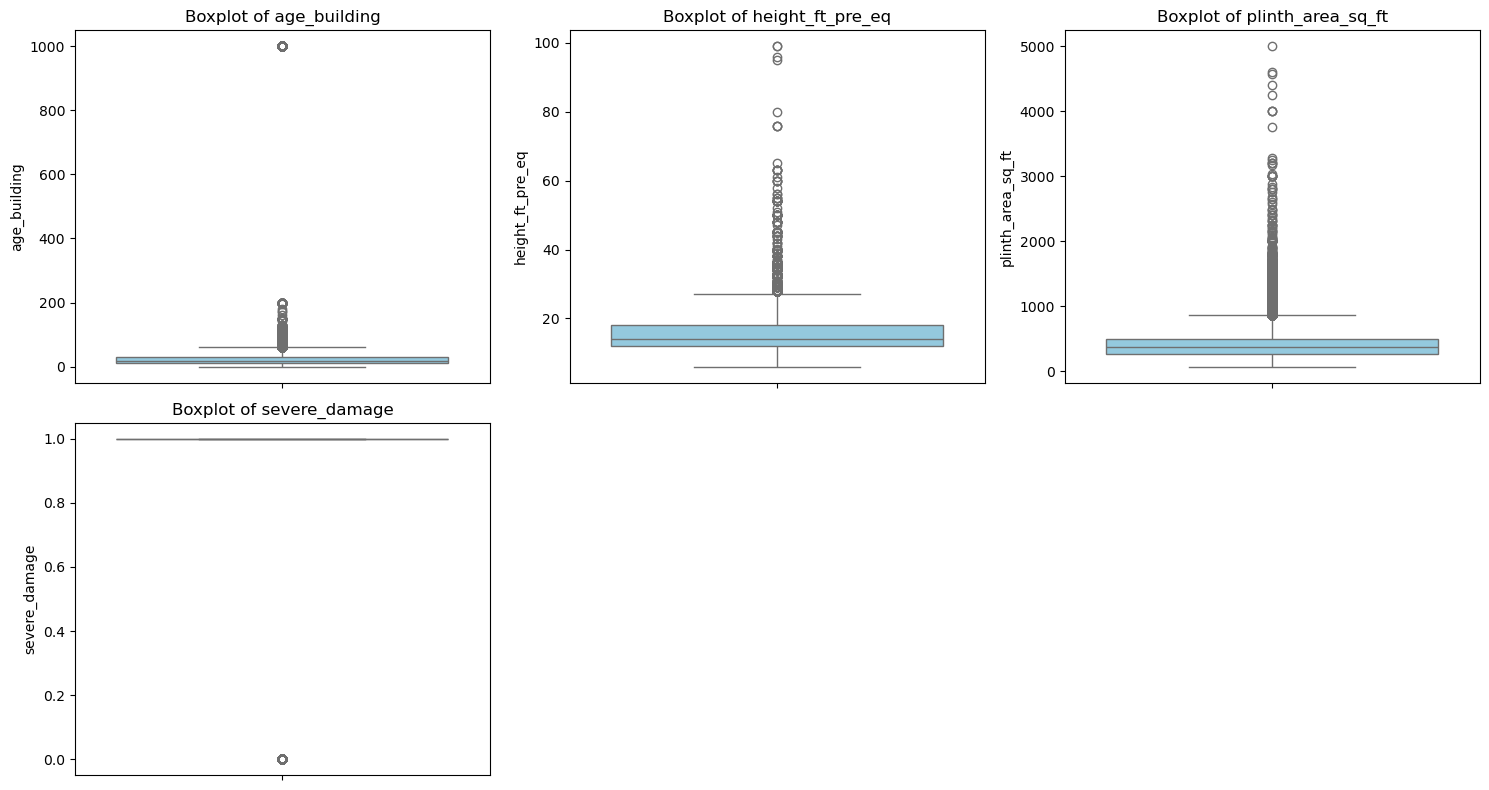

In [73]:
num_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Plot boxplots for each numerical column to visualize outliers
ncols = 3
nrows = math.ceil(len(num_cols) / ncols)
plt.figure(figsize=(5 * ncols, 4 * nrows))
for i, col in enumerate(num_cols):
    ax = plt.subplot(nrows, ncols, i + 1)   # supply index as third arg
    sns.boxplot(y=data[col], color='skyblue', ax=ax)
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Outliers are kept because they may represent real and important cases rather than errors. In risk-related problems, extreme values often correspond to rare but critical events the model needs to learn. Removing them could discard useful information, distort the dataset, and weaken the model’s ability to detect high-impact scenarios.

In [74]:
data.shape

(78074, 12)

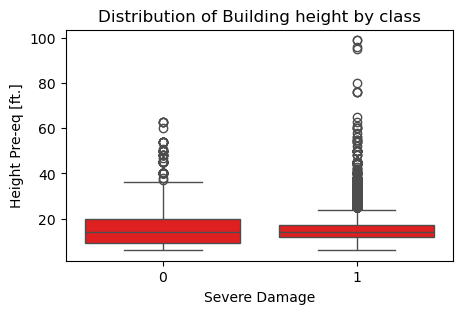

In [75]:
plt.figure(figsize=(5,3))
sns.boxplot(x='severe_damage', y='height_ft_pre_eq', data=data, color='red')
# Label axes
plt.xlabel('Severe Damage')
plt.ylabel('Height Pre-eq [ft.]')
plt.title('Distribution of Building height by class');

<Axes: title={'center': 'Class Balance'}, xlabel='Class', ylabel='Relative Frequency'>

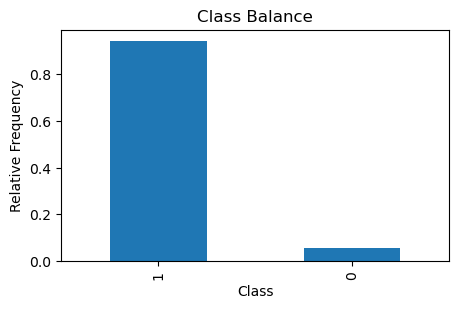

In [76]:
plt.figure(figsize=(5,3))
data['severe_damage'].value_counts(normalize=True).plot(
    kind='bar',
    xlabel='Class', ylabel='Relative Frequency', title='Class Balance',
)

In [77]:
counts = data['severe_damage'].value_counts()
percentage = counts / len(data['severe_damage']) * 100

SVD = pd.DataFrame({"Severe_damage_counts": counts,
              "percentage": percentage})
SVD

,Severe_damage_counts,percentage
severe_damage,,
1,73723,94.427082
0,4351,5.572918


In [78]:
foundation_pivot = pd.pivot_table(
    data, index='foundation_type', values='severe_damage', aggfunc='mean'
).sort_values(by='severe_damage')
foundation_pivot

,severe_damage
foundation_type,
RC,0.484706
Bamboo/Timber,0.709302
Cement-Stone/Brick,0.84442
Other,0.919643
Mud mortar-Stone/Brick,0.979402


<Figure size 500x300 with 0 Axes>

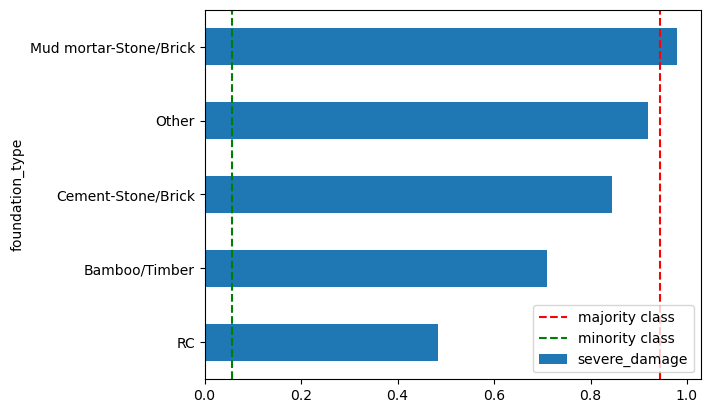

In [79]:
plt.figure(figsize=(5,3))
foundation_pivot.plot(kind='barh')
plt.axvline(
    (SVD['percentage'].iloc[0] / 100), linestyle='--', color='red', label='majority class'
)
plt.axvline(
    (SVD['percentage'].iloc[1] / 100), linestyle='--', color='green', label='minority class'
)
plt.legend(loc='lower right')
plt.show()

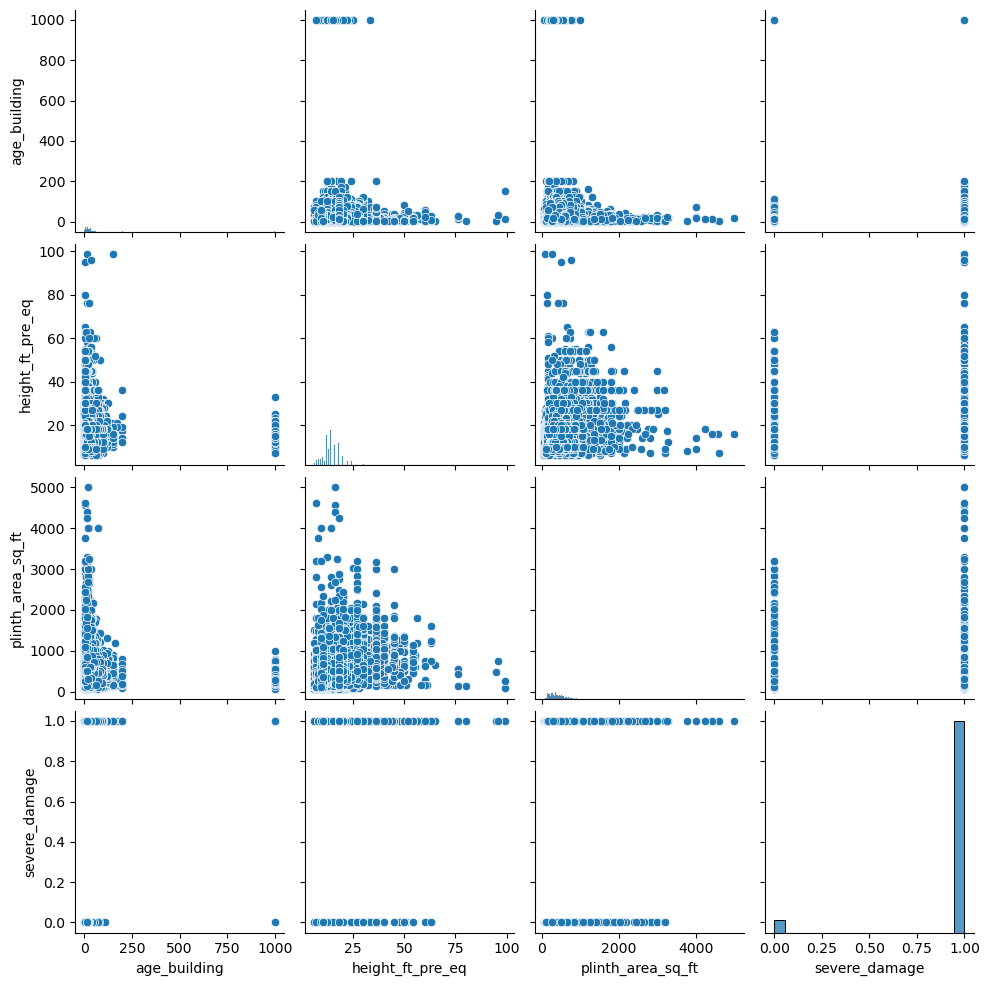

In [80]:
# Also visualize with pairplot to see relationships and noisy patterns
sns.pairplot(data[num_cols])
plt.show()

Checking for correlation between the numerical columns 

In [81]:
numeric_df = data.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_df.corr()
corr_matrix

,age_building,height_ft_pre_eq,plinth_area_sq_ft,severe_damage
age_building,1.000000,0.047666,-0.019476,0.049246
height_ft_pre_eq,0.047666,1.000000,0.286794,-0.056049
plinth_area_sq_ft,-0.019476,0.286794,1.000000,-0.169297
severe_damage,0.049246,-0.056049,-0.169297,1.000000


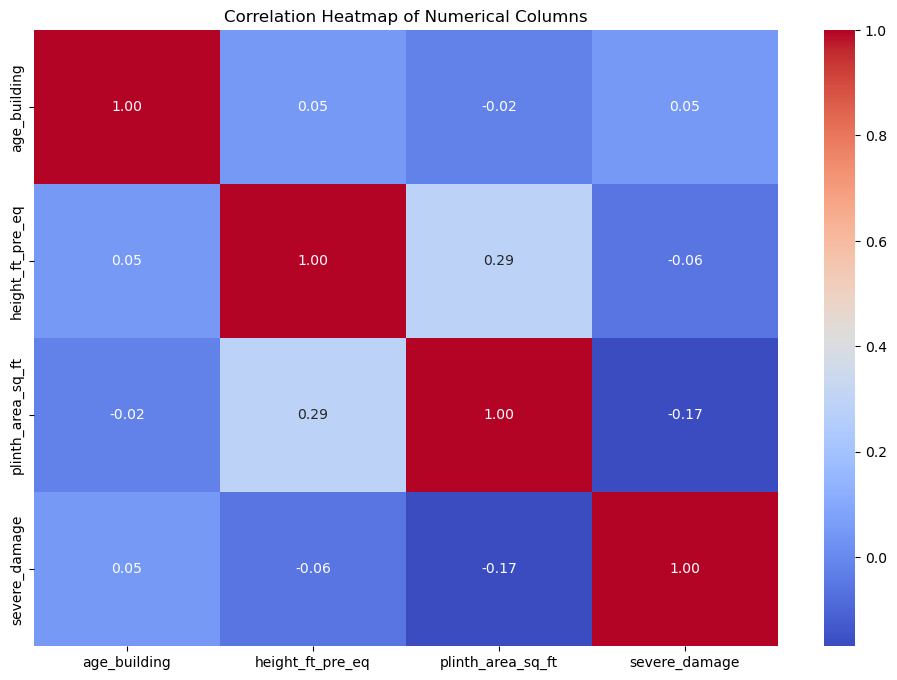

In [82]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Numerical Columns")
plt.show()

In [83]:
data.columns

Index(['age_building', 'foundation_type', 'ground_floor_type',
       'height_ft_pre_eq', 'land_surface_condition', 'other_floor_type',
       'plan_configuration', 'plinth_area_sq_ft', 'position', 'roof_type',
       'superstructure', 'severe_damage'],
      dtype='object')

In [84]:
Features = ['age_building', 'foundation_type', 'ground_floor_type',
       'height_ft_pre_eq', 'land_surface_condition', 'other_floor_type',
       'plan_configuration', 'plinth_area_sq_ft', 'position', 'roof_type',
       'superstructure']
target = ['severe_damage']

In [85]:
X = data[Features]
y = data[target]

In [86]:
X.head()

,age_building,foundation_type,ground_floor_type,height_ft_pre_eq,land_surface_condition,other_floor_type,plan_configuration,plinth_area_sq_ft,position,roof_type,superstructure
0,4,Mud mortar-Stone/Brick,Mud,18,Flat,TImber/Bamboo-Mud,Rectangular,280,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
1,15,Mud mortar-Stone/Brick,Mud,18,Flat,Not applicable,Rectangular,120,Attached-1 side,Bamboo/Timber-Light roof,mud_mortar_stone
2,25,Mud mortar-Stone/Brick,Mud,14,Flat,TImber/Bamboo-Mud,Rectangular,300,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
3,22,Mud mortar-Stone/Brick,Mud,16,Flat,TImber/Bamboo-Mud,Rectangular,155,Not attached,Bamboo/Timber-Light roof,mud_mortar_stone
4,20,Mud mortar-Stone/Brick,Brick/Stone,14,Flat,TImber/Bamboo-Mud,Rectangular,240,Attached-1 side,Bamboo/Timber-Heavy roof,mud_mortar_stone


In [87]:
display(y.shape)
display(y.head())

(78074, 1)

,severe_damage
0,1
1,1
2,1
3,1
4,1


ENCODING CATEGORICAL VARIABLES In features

In [88]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_array = ohe.fit_transform(X[cat_cols])

In [89]:
ohe_df = pd.DataFrame(ohe_array, columns=ohe.get_feature_names_out(cat_cols))

In [90]:
ohe_df.index = X.index

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
num_df = X[numeric_cols]

X_final = pd.concat([num_df, ohe_df], axis=1)

In [91]:
X_final.shape

(78074, 48)

Splitting our data

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [93]:
len(X_train), len(y_train), len(X_test), len(y_test)

(62459, 62459, 15615, 15615)

In [94]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [95]:
model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    seed=42,
    n_estimators=300,
    learning_rate=0.09,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight= 1.5,
    eval_metric='logloss'
)

In [96]:
model.fit(
    X_train_res, y_train_res.values.ravel(),
    verbose=True
)

c:\Users\ajifo\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:56:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [97]:
model.score(X_train, y_train.values.ravel())

0.9622632446885157

In [98]:
y_proba = model.predict_proba(X_test)[:, 1]

for t in [0.3, 0.4, 0.5, 0.6]:
    print(f"Threshold = {t}")
    y_pred_adj = (y_proba > t).astype(int)

Threshold = 0.3
Threshold = 0.4
Threshold = 0.5
Threshold = 0.6


In [99]:
display(accuracy_score(y_test, y_pred_adj))
display(classification_report(y_test, y_pred_adj))
display(confusion_matrix(y_test, y_pred_adj))

0.9539545308997759

'              precision    recall  f1-score   support\n\n         0.0       0.59      0.58      0.58       870\n         1.0       0.98      0.98      0.98     14745\n\n    accuracy                           0.95     15615\n   macro avg       0.78      0.78      0.78     15615\nweighted avg       0.95      0.95      0.95     15615\n'

array([[  506,   364],
       [  355, 14390]], dtype=int64)

Using GridSearch

In [95]:
model2 = XGBClassifier(objective='binary:logistic',
                          seed=42,
                          subsample=0.9,
                          colsample_bytree=0.5
                          )

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 400, 600],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1, 5]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [96]:
grid.fit(X_train_res, y_train_res.values.ravel())

Fitting 3 folds for each of 324 candidates, totalling 972 fits


c:\Users\ajifo\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:24:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=300,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1], 'gamma': [0, 1, 5],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [200, 400, 600],
                         'subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [97]:
grid.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 600,
 'subsample': 0.8}

In [98]:
grid.best_score_

0.7165987977506303

In [100]:
model2 = XGBClassifier( objective='binary:logistic',
    use_label_encoder=False,
    seed=42,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.1,
    max_depth=8,
    n_estimators=600,
    subsample=0.8,
    scale_pos_weight= 2.1,
    eval_metric='logloss',
    reg_lambda=3,
    reg_alpha=0.1
    )
model2.fit(X_train_res, y_train_res.values.ravel(), verbose=True)

c:\Users\ajifo\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:57:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, ...)

In [101]:
model2.score(X_train, y_train.values.ravel())

0.9819881842488672

In [102]:
y_proba = model2.predict_proba(X_test)[:, 1]

for t in [0.3, 0.4, 0.5, 0.6]:
    print(f"Threshold = {t}")
    y_pred_adj = (y_proba > t).astype(int)

Threshold = 0.3
Threshold = 0.4
Threshold = 0.5
Threshold = 0.6


In [103]:
display(accuracy_score(y_test, y_pred_adj))
display(classification_report(y_test, y_pred_adj))
display(confusion_matrix(y_test, y_pred_adj))

0.9533141210374639

'              precision    recall  f1-score   support\n\n         0.0       0.60      0.49      0.54       870\n         1.0       0.97      0.98      0.98     14745\n\n    accuracy                           0.95     15615\n   macro avg       0.78      0.74      0.76     15615\nweighted avg       0.95      0.95      0.95     15615\n'

array([[  429,   441],
       [  288, 14457]], dtype=int64)

In [104]:

features = X_final.columns

# XGBoost feature importances (aligned with features)
importances = model2.feature_importances_

# quick view
fi = pd.Series(importances, index=features).sort_values(ascending=False)
fi.head(20)

foundation_type_Mud mortar-Stone/Brick    0.288541
superstructure_mud_mortar_stone           0.174810
superstructure_stone_flag                 0.158302
roof_type_Bamboo/Timber-Heavy roof        0.037092
superstructure_mud_mortar_brick           0.031033
foundation_type_Cement-Stone/Brick        0.028649
superstructure_adobe_mud                  0.027101
other_floor_type_Timber-Planck            0.025568
other_floor_type_Not applicable           0.024649
position_Not attached                     0.016972
roof_type_RCC/RB/RBC                      0.015277
land_surface_condition_Flat               0.013196
superstructure_rc_non_engineered          0.009035
superstructure_cement_mortar_brick        0.008969
roof_type_Bamboo/Timber-Light roof        0.008799
foundation_type_Bamboo/Timber             0.008506
superstructure_timber                     0.008322
land_surface_condition_Moderate slope     0.008223
superstructure_other                      0.008204
other_floor_type_TImber/Bamboo-

In [105]:
print(model2.get_booster().get_score(importance_type='gain'))

{'age_building': 4.458251953125, 'height_ft_pre_eq': 2.4666404724121094, 'plinth_area_sq_ft': 2.4857819080352783, 'foundation_type_Bamboo/Timber': 12.593632698059082, 'foundation_type_Cement-Stone/Brick': 42.41465759277344, 'foundation_type_Mud mortar-Stone/Brick': 427.1875, 'foundation_type_Other': 6.485255718231201, 'foundation_type_RC': 9.240804672241211, 'ground_floor_type_Brick/Stone': 6.104599475860596, 'ground_floor_type_Mud': 7.935314655303955, 'ground_floor_type_Other': 2.6490983963012695, 'ground_floor_type_RC': 11.768972396850586, 'ground_floor_type_Timber': 1.9159502983093262, 'land_surface_condition_Flat': 19.536394119262695, 'land_surface_condition_Moderate slope': 12.17427921295166, 'land_surface_condition_Steep slope': 4.972424507141113, 'other_floor_type_Not applicable': 36.49313735961914, 'other_floor_type_RCC/RB/RBC': 5.227471828460693, 'other_floor_type_TImber/Bamboo-Mud': 11.903985977172852, 'other_floor_type_Timber-Planck': 37.85321044921875, 'plan_configuration_L

randomsearch

In [ ]:
model3 = XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    tree_method="hist",   
    random_state=42,     
)

param_dist = {
    'n_estimators': randint(100, 1000),
    "max_depth": [3, 4, 5, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "min_child_weight": [1, 3, 5, 7, 10],
    "subsample": np.linspace(0.5, 1.0, 6),
    "colsample_bytree": np.linspace(0.3, 1.0, 8),
    "gamma": [0, 0.1, 0.3, 1, 3, 5],
    "reg_alpha": [0, 0.1, 0.3, 1],
    "reg_lambda": [0.1, 1, 3, 5, 10],
    "scale_pos_weight": [1, 2, 5, 10, 20]
}

random_search = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_dist,
    n_iter=60,                     # number of random combinations to try
    scoring="roc_auc",             # or accuracy, f1, etc.
    cv=5,                          # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                      # use all CPU cores
)

random_search.fit(X_train_res, y_train_res.values.ravel())

In [244]:
random_search.best_params_

{'colsample_bytree': 0.7999999999999999,
 'gamma': 0,
 'learning_rate': 0.1388888888888889,
 'max_depth': 10,
 'min_child_weight': 7,
 'n_estimators': 127,
 'reg_alpha': 1,
 'reg_lambda': 5,
 'scale_pos_weight': 10,
 'subsample': 1.0}

In [245]:
random_search.best_score_

0.8391345377666946

In [106]:
model3 = XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    tree_method="hist",   
    random_state=42,
    colsample_bytree=0.7,
    gamma=0,
    learning_rate=0.1,
    max_depth=10,
    min_child_weight=5,
    n_estimators=300,
    reg_alpha=1,
    reg_lambda=5,
    scale_pos_weight=1.7,
    subsample=1.0     
)

NOTE: I modify the params RandomSearch gave. I did'nt use exactly all the params it gave.

In [107]:
model3.fit(X_train_res, y_train_res.values.ravel(), verbose=True)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [108]:
model3.score(X_train_res, y_train_res.values.ravel())

0.975558682898708

In [109]:
y_proba = model3.predict_proba(X_test)[:, 1]

for t in [0.3, 0.4, 0.5, 0.6]:
    print(f"Threshold = {t}")
    y_pred_adj = (y_proba > t).astype(int)

Threshold = 0.3
Threshold = 0.4
Threshold = 0.5
Threshold = 0.6


In [110]:
display(accuracy_score(y_test, y_pred_adj))
display(classification_report(y_test, y_pred_adj))
display(confusion_matrix(y_test, y_pred_adj))

0.954338776817163

'              precision    recall  f1-score   support\n\n         0.0       0.61      0.51      0.56       870\n         1.0       0.97      0.98      0.98     14745\n\n    accuracy                           0.95     15615\n   macro avg       0.79      0.75      0.77     15615\nweighted avg       0.95      0.95      0.95     15615\n'

array([[  446,   424],
       [  289, 14456]], dtype=int64)

In [114]:
features = X_final.columns

# XGBoost feature importances (aligned with features)
importances = model3.feature_importances_

# quick view
fi = pd.Series(importances, index=features).sort_values(ascending=False)
fi.head(20)

foundation_type_Mud mortar-Stone/Brick    0.294942
superstructure_mud_mortar_stone           0.214328
superstructure_stone_flag                 0.104748
roof_type_Bamboo/Timber-Heavy roof        0.043105
superstructure_mud_mortar_brick           0.034918
other_floor_type_Timber-Planck            0.031133
foundation_type_Other                     0.024811
other_floor_type_Not applicable           0.024446
foundation_type_Cement-Stone/Brick        0.021889
superstructure_adobe_mud                  0.021073
position_Not attached                     0.015768
land_surface_condition_Flat               0.012901
roof_type_Bamboo/Timber-Light roof        0.012593
other_floor_type_TImber/Bamboo-Mud        0.012545
superstructure_cement_mortar_brick        0.010240
superstructure_other                      0.009728
superstructure_timber                     0.009347
land_surface_condition_Moderate slope     0.009122
superstructure_rc_non_engineered          0.007959
roof_type_RCC/RB/RBC           

model3 importance features is basically saying:

The foundation_type_Mud mortar-Stone/Brick feature, superstructure_mud_mortar_stone and superstructure_stone_flag are by far the most important variable for prediction. The roof_type_Bamboo/Timber-Heavy roof, other_floor_type_Timber-Planck and superstructure_mud_mortar_brick also influence predictions but less strongly.

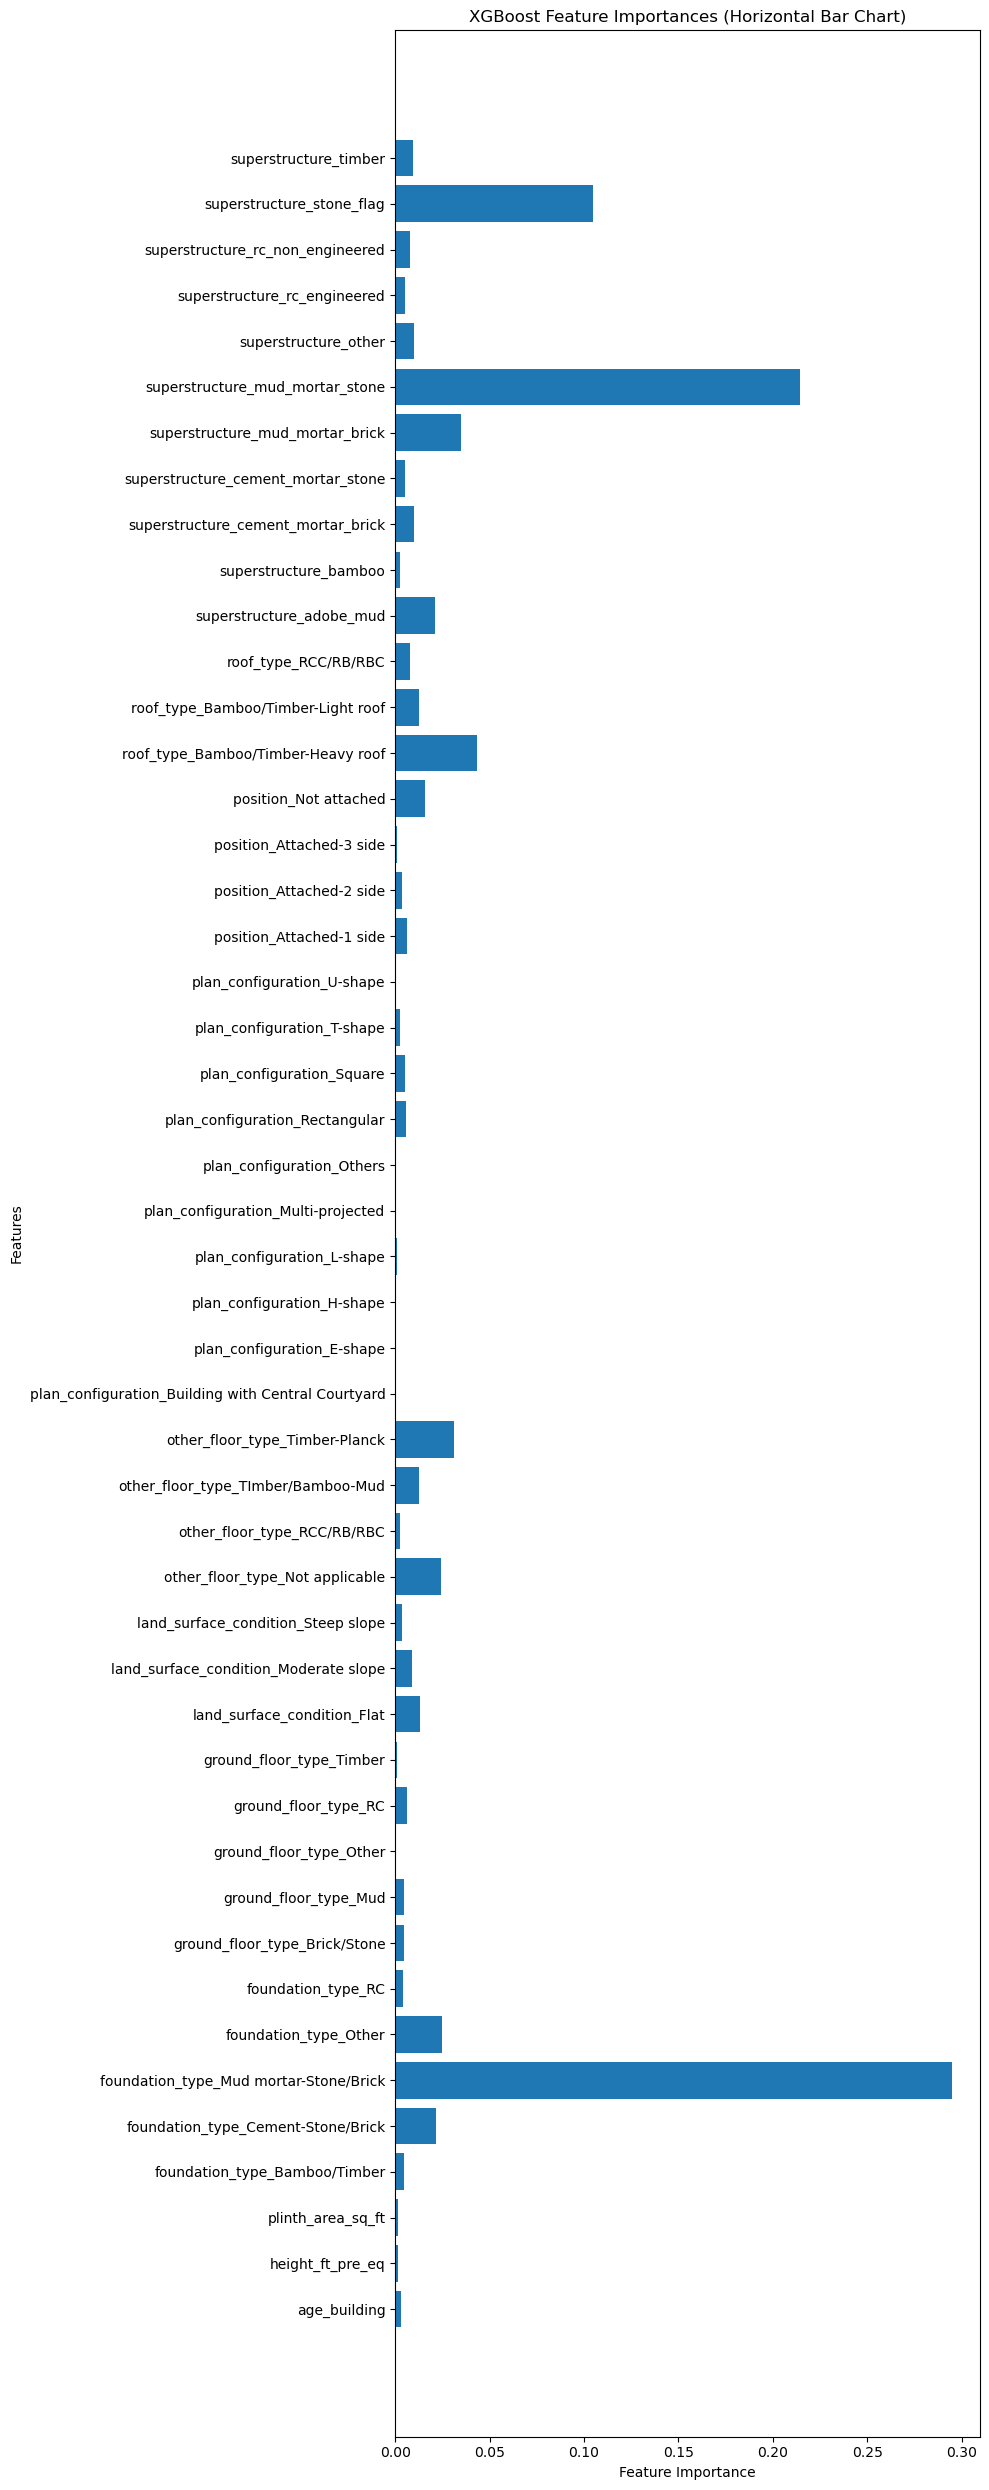

In [115]:
plt.figure(figsize=(10, 25))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importances (Horizontal Bar Chart)")
plt.tight_layout()
plt.show()

In [286]:
import pickle

In [491]:
artifacts = {
    "model": model3,
    "ohe": ohe,
    "cat_cols": list(cat_cols),
    "numeric_cols": list(numeric_cols),
    "feature_columns": list(X_final.columns),
    "threshold": [0.3, 0.4, 0.5, 0.6]
}

In [492]:
with open('nepal_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)